In [19]:
import numpy as np
import matplotlib.pyplot as plt

from opencood.utils import pcd_utils
import open3d as o3d
from sklearn.linear_model import RANSACRegressor
from scipy.spatial import ConvexHull
from skimage.draw import line
from scipy.ndimage import binary_dilation, binary_erosion

true_ego_pos = np.array([602.579345703125, 141.94232177734375, 0.03614355996251106])  #Subject to change accroding to config file




In [31]:

def exclude_points_near_lidar(point_cloud, lidar_pose, radius=3.0):
    """
    Exclude points within a certain radius from the LiDAR pose.

    Args:
        point_cloud (np.ndarray): N x 3 array of LiDAR points (x, y, z).
        lidar_pose (tuple): LiDAR pose as (x, y, z).
        radius (float): Radius within which points will be excluded.

    Returns:
        np.ndarray: Filtered point cloud.
    """
    # Compute Euclidean distances from the LiDAR pose
    distances = np.linalg.norm(point_cloud[:, :3] - np.array(lidar_pose[:3]), axis=1)

    # Filter out points within the specified radius
    filtered_points = point_cloud[distances > radius]
    # Create Open3D PointCloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(filtered_points)

    return pcd,filtered_points

def preprocess(pcd_np,sample_num=None):
    """
    Preprocess lidar points with downsampling and near-point exclusion.

    Parameters
    ----------
    pcd_np : np.ndarray
        Raw lidar points.

    Returns
    -------
    np.ndarray
        Processed point cloud.
    """
    if sample_num is not None:
        sample_num = 20000
        pcd_np = pcd_utils.downsample_lidar(pcd_np, sample_num)
    
    # Exclude points near lidar
    _, filtered_points = exclude_points_near_lidar(pcd_np, true_ego_pos)

    
    return filtered_points

def project_points_to_bev_map(points, ratio=0.1):
    """
    Project points to BEV occupancy map with default ratio=0.1.

    Parameters
    ----------
    points : np.ndarray
        (N, 3) / (N, 4)

    ratio : float
        Discretization parameters. Default is 0.1.

    Returns
    -------
    bev_map : np.ndarray
        BEV occupancy map including projected points with shape
        (img_row, img_col).

    """
    #Changed using default cavlidar range

    L1, W1, H1, L2, W2, H2 = -60.8, -20, -3, 60.8, 20, 1
    img_row = int((L2 - L1) / ratio)
    img_col = int((W2 - W1) / ratio)
    bev_map = np.zeros((img_row, img_col))
    bev_origin = np.array([L1, W1, H1]).reshape(1, -1)
    # (N, 3)
    indices = ((points[:, :3] - bev_origin) / ratio).astype(int)
    mask = np.logical_and(indices[:, 0] > 0, indices[:, 0] < img_row)
    mask = np.logical_and(mask, np.logical_and(indices[:, 1] > 0,
                                                indices[:, 1] < img_col))
    indices = indices[mask, :]
    bev_map[indices[:, 0], indices[:, 1]] = 1
    return bev_map

# Ocuupancy COde

In [29]:
def create_improved_occupancy_map(points, ratio=0.1, ransac_threshold=0.3):
    # Ground plane removal
    ransac = RANSACRegressor(residual_threshold=ransac_threshold)
    X = points[:, [0, 1]]
    y = points[:, 2]
    ransac.fit(X, y)
    ground_mask = np.abs(ransac.predict(X) - y) > ransac_threshold
    filtered_points = points[ground_mask]
    
    L1, W1, H1, L2, W2, H2 = -60.8, -20, -3, 60.8, 20, 1
    img_row = int((L2 - L1) / ratio)
    img_col = int((W2 - W1) / ratio)
    
    occupancy_map = np.zeros((img_row, img_col))
    density_map = np.zeros((img_row, img_col))
    
    ego_x = int((true_ego_pos[0] - L1) / ratio)
    ego_y = int((true_ego_pos[1] - W1) / ratio)
    
    # Project points and calculate density
    bev_origin = np.array([L1, W1, H1]).reshape(1, -1)
    indices = ((filtered_points[:, :3] - bev_origin) / ratio).astype(int)
    
    mask = np.logical_and.reduce([
        indices[:, 0] >= 0, indices[:, 0] < img_row,
        indices[:, 1] >= 0, indices[:, 1] < img_col
    ])
    indices = indices[mask]
    
    # Count points per cell
    for x, y in indices[:, :2]:
        density_map[x, y] += 1
    
    # Normalize density
    density_threshold = np.percentile(density_map[density_map > 0], 50)
    
    # Process points with density consideration
    for x, y in indices[:, :2]:
        if density_map[x, y] >= density_threshold:
            rr, cc = line(ego_x, ego_y, x, y)
            valid_mask = np.logical_and.reduce([
                rr >= 0, rr < img_row,
                cc >= 0, cc < img_col
            ])
            rr, cc = rr[valid_mask], cc[valid_mask]
            
            # Mark path and endpoint
            occupancy_map[rr[:-1], cc[:-1]] = 0  # free space
            occupancy_map[x, y] = 1  # occupied space
    
    # Clean up
    kernel = np.ones((3, 3))
    occupancy_map = binary_dilation(occupancy_map, kernel)
    
    return occupancy_map

def visualize_dual_occupancy(occupancy_map, points, ratio=0.1):
    L1, W1 = -60.8, -20
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plain occupancy map
    im1 = ax1.imshow(occupancy_map, cmap='binary')
    ax1.set_title('Occupancy Map')
    plt.colorbar(im1, ax=ax1)
    
    # Occupancy map with point overlay
    im2 = ax2.imshow(occupancy_map, cmap='binary')
    grid_points = ((points[:, :2] - np.array([L1, W1])) / ratio).astype(int)
    ax2.scatter(grid_points[:, 1], grid_points[:, 0], c='red', s=1, alpha=0.3, label='LiDAR points')
    ax2.set_title('Occupancy Map with Point Cloud')
    plt.colorbar(im2, ax=ax2)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [5]:
# Load the PCD file
pcd_file_path = '/home/xavierallem/Opencood_testing/OpenCOOD/OPV2V/scenario_train/2021_08_18_09_02_56/440/000068.pcd'
pcd = o3d.io.read_point_cloud(pcd_file_path)
points = np.asarray(pcd.points)

In [14]:
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: GLX: Failed to create context: GLXBadFBConfig
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


In [9]:
bev_map=project_points_to_bev_map(preprocess(points))

In [11]:
bev_map=project_points_to_bev_map(points)

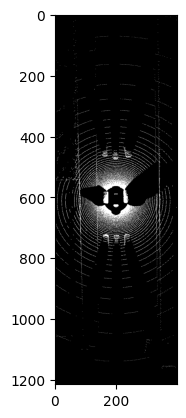

In [12]:
plt.imshow(bev_map, cmap='gray')
plt.show()

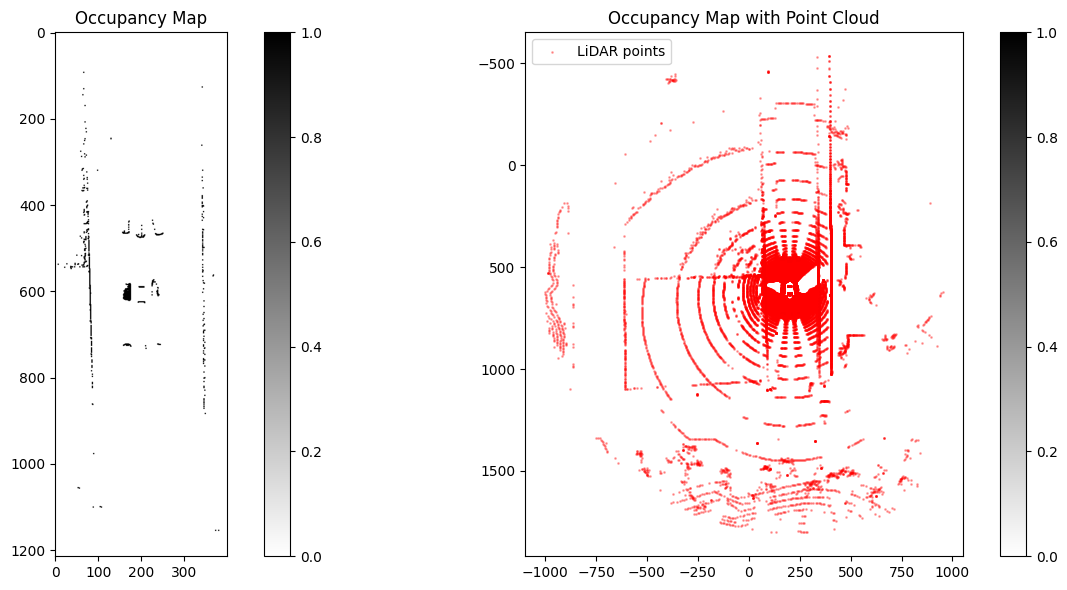

In [32]:
occupancy_map = create_improved_occupancy_map(preprocess(points))
visualize_dual_occupancy(occupancy_map, points)

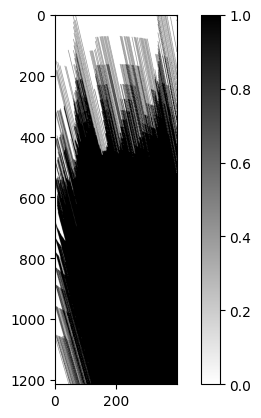